In [1]:
#parameters
station_name = 'Poole_harbor'
particle_size = 1000
region_size = 1
runtime_d = 30 #runtime in days
timestep_m = 15 # timestep in minutes
seed = 0

## first parcels test

* first test with real data 

In [3]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy as crs
cwd =os.getcwd()

In [4]:
#load velocity data
path = cwd +'/data/'
data = 'MetO-NWS-PHY-dm-CUR_1658776649348.nc'
ds = nc.Dataset(path + data)

lon_grid =  ds['lon'][:]
lat_grid =  ds['lat'][:]
print(ds)
print(lat_grid)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: daily-mean horizontal velocity (3D)
    Conventions: CF-1.7
    source: PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWATCH-III v4.18_NEMOVAR v6
    contact: servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id: netCDF-4
    references: http://marine.copernicus.eu/
    creation_date: 2022-07-25T08:45:09Z
    institution: UK Met Office
    history: See source and creation_date attributes
    forcing_data_source: ECMWF Global Atmospheric Model (HRES); CMEMS-MERCATOR12; UKMO GLOWave; CMEMS-BALTIC; climatological rivers
    product: NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit: E.U. Copernicus Marine Service Information (CMEMS)
    licence: http://marine.copernicus.eu/services-portfolio/service-commitments-and-licence/
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    comment: 
    dimensions(sizes): time(92), depth(1), lat(1240), lon(958)
    variables(

In [5]:
#readingmutiple  netcdf velocity files  
filenames = path + data
#ilenames = {'U' :"MovingEddies_data/moving_eddiesU.nc",
#             'V' :"MovingEddies_data/moving_eddiesV.nc"}
variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'
              }

fieldset = FieldSet.from_netcdf(filenames,variables,dimensions)

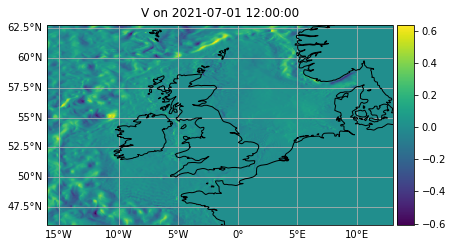

In [6]:
fieldset.V.show()

* construnct function to generate particles at each station from the station.csv data (1°x1°)

In [7]:
stations = pd.read_csv("data/stations.csv")
stations
#for ind, row in stations.iterrows():   
#    lats_e, lons_e = genStationParticles(row['lat'],row['lon'], Num = 100)

,station,country,lat,lon
0,Walton_Backwaters,UK_eastcoast,51.862920,1.290133
1,Poole_harbor,UK_channel,50.683427,-1.943239
2,Sylt,Germany,55.029428,8.433999
3,Bourgneuf_Bay,\tFrance,46.986492,-2.040351


In [21]:
dom = {'N':60, 'S':46, 'E':12.5, 'W':-4}#


def genStationParticle(station_name, num = 1000, size = 1):

    '''
    generates [num] number of random coordinates 
    in a box centered around [lat,lon] of a station from station.csv with a side length of [size]
    '''
    index = stations[stations['station'] == station_name].index[0]
    print(f'Station: {stations.loc[index,"station"]}')
    
    lat = stations.loc[index,'lat']
    lon = stations.loc[index,'lon']
    
    
    lon_bound = (lon - size/2, lon + size/2)
    lat_bound = (lat - size/2, lat + size/2)
    lons = np.random.uniform(low=lon_bound[0], high = lon_bound[1], size=num)
    lats = np.random.uniform(low=lat_bound[0], high = lat_bound[1], size=num)
        
    #maybe check for land in possible particle start location?
    
    pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=lons, # a vector of release longitudes 
                             lat=lats)    # a vector of release latitudes

    pset.show(field=fieldset.U,domain = dom)    
    return pset

Station: Poole_harbor


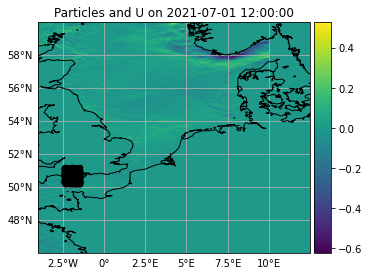

In [22]:
np.random.seed(seed)
pset = genStationParticle(station_name = station_name, num = particle_size, size = region_size)

In [18]:
#pset_sylt.show(field=fieldset.U,domain =  {'N':56, 'S':54, 'E':10, 'W':7.5})  

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-1000/lib67c4ae5206481fccdf626d0542f60fd5_0.so
INFO: Temporary output files are stored in out-WOHGXERY.
INFO: You can use "parcels_convert_npydir_to_netcdf out-WOHGXERY" to convert these to a NetCDF file during the run.
100%|████████████████████████| 2592000.0/2592000.0 [00:01<00:00, 2487457.84it/s]


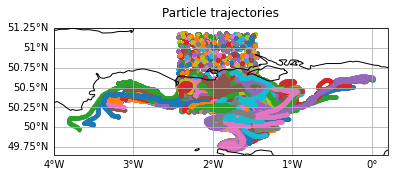

In [23]:
output_file = pset.ParticleFile(name="output_particles.nc", outputdt=timedelta(hours=1)) # the file name and the time step of the outputs
pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=runtime_d),    # the total length of the run
             dt=timedelta(minutes=timestep_m),      # the timestep of the kernel
             output_file=output_file)
#pset.show(field='vector')
message_str = f"particle set with:\n station name: {station_name}\n runtime: {runtime_d} days\n simulation timestep: {timestep_m} minutes\n particle number: {particle_size}\noutput_timestep: 1 hour "
output_file.add_metadata(name = station_name, message = message_str)
output_file.export()
plotTrajectoriesFile('output_particles.nc');